In [85]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# SK-learn libraries for data processing.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier    
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn import metrics

In [138]:
# Load data using pandas.
train_data = pd.read_csv('data/train_users_2.csv')
test_data = pd.read_csv('data/test_users.csv')
print "Train data shape: {0}".format(train_data.shape)
print "--------------Train Data----------------------"
print train_data.info()
print "----------------------------------------------"

print "\n"
print "Test data shape: {0}".format(test_data.shape)
print "---------------Test Data----------------------"
print test_data.info()
print "----------------------------------------------"

Train data shape: (213451, 16)
--------------Train Data----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float

In [141]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add age to features.
    # Set NA values to -1.
    data["age"] = data["age"].fillna(-1)
    # Add age data to training data.
    features_data = np.column_stack((features_data, np.array(data["age"])))
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(train_data)
test_data_x = ExtractFeatures(test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


### Exploring the data

#### Cleaning age data
We'll start with the assumption that valid age ranges should be between 18-100 since the minimum age according to the Terms of Service is 18. Any values outside of this range should be cleaned into valid values or set to 0
as invalid.

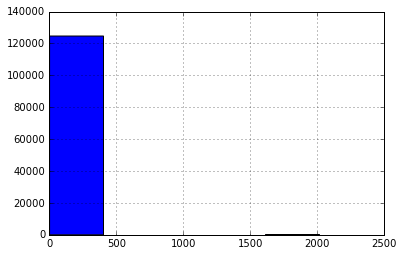

In [89]:
# Get all age values that are greater than zero.
GTE_zero_age = train_data[train_data.age >= 0].age
# Plot a histogram of these values.
GTE_zero_age.hist(bins=5)

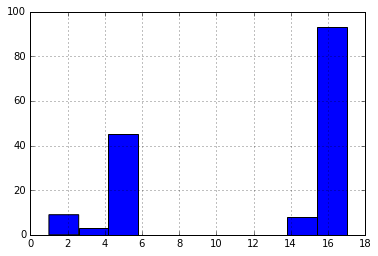

In [91]:
# Get all age values that are between 0 and 18.
under_18 = GTE_zero_age[GTE_zero_age < 18]
under_18.hist()
# All these values should be treated as invalid values.

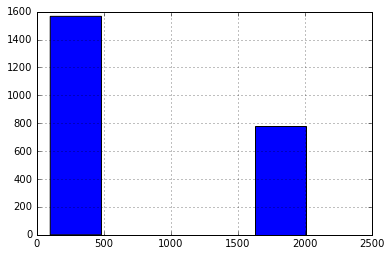

In [92]:
# From this, we can see that there are many large values.
# Assuming anything above 100 is not a valid, let's plot the
# histogram of those values.
GT_150 = train_data[train_data.age > 100].age
GT_150.hist(bins=5)
# We can't make much sense out of values between 100-1915 so
# those should be treated as invalid values as well.

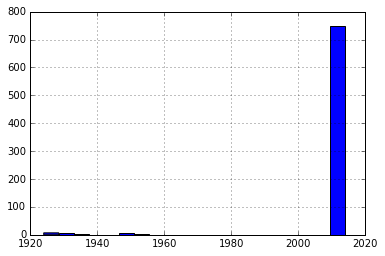

In [93]:
# Let's look more closely at those values greater than 1915.
GT_1915 = train_data[train_data.age > 1915].age
GT_1915.hist(bins=20)
# We have some values between 1915 and 1997 which we can
# assume could be birth years.
# The large number of values > 1997 are likely the current
# year the user registered.

In [152]:
# Helper function to clean up the age data based off
# this analysis in both the training and test data.
def CleanAgeData(df):
    age_data = df.age
    # Set missing values to -1.
    age_data = age_data.fillna(-1)
    # Set invalid values to 0.
    # Values between 0-18 are considered invalid.
    age_data[age_data.isin(range(0,18))] = 0
    # Values between 100-1915 are considered invalid.
    age_data[age_data.isin(range(101,1915))] = 0
    # Values >2010 are considered invalid.
    age_data[age_data > 1997] = 0
    # Compute age for values between 1915-1997.
    age_data[age_data.isin(range(1915,1998))] = 2015 - age_data[age_data.isin(range(1915,1998))]
    return age_data

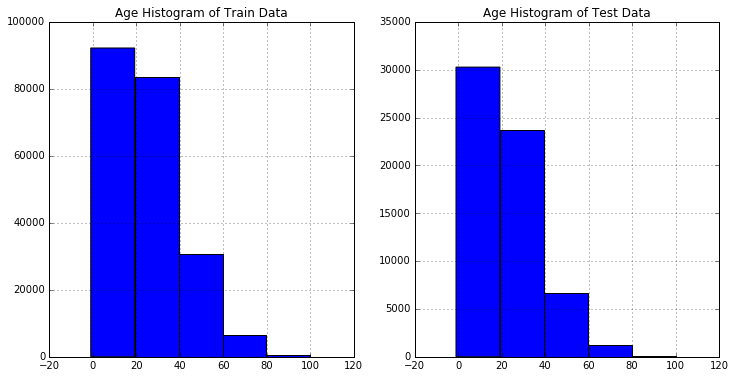

In [153]:
# Clean up training and test age data and plot cleaned data.
plt.figure(figsize=(12, 6))
train_age_data = CleanAgeData(train_data)
plt.subplot(1, 2, 1)
train_age_data.hist(bins=5)
plt.title("Age Histogram of Train Data")

test_age_data = CleanAgeData(test_data)
plt.subplot(1, 2, 2)
test_age_data.hist(bins=5)
plt.title("Age Histogram of Test Data")

### Preparing Data

In [154]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add age to features.
    age_data = CleanAgeData(data)
    # Add age data to training data.
    features_data = np.column_stack((features_data, np.array(age_data)))
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(train_data)
test_data_x = ExtractFeatures(test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


In [155]:
# Split train data into training and dev sets.
train_data_size = (len(train_data_x))/5*4
train_x, train_y = train_data_x[:train_data_size], train_data_y[:train_data_size]
dev_x, dev_y= train_data_x[train_data_size:], train_data_y[train_data_size:]

# save dev id to be used in score calculation
dev_id = np.array(train_data["id"][train_data_size:])
dev_dict = dict(zip(dev_id, dev_y))

print train_x.shape, train_y.shape
print dev_x.shape, dev_y.shape, dev_id.shape

(170760, 6) (170760,)
(42691, 6) (42691,) (42691,)


In [125]:
# Calculate DCG score based on Kaggle evaluation doc
def FinalScore(predictions):
    to_print = False
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)

    return score/num_pred

In [126]:
# Helper function to return top 5 prediction result per example
# given a trained model.
def Predict_Top5(m):
    prob_est = m.predict_proba(dev_x)
    predictions = []
    
    for i, example in enumerate(prob_est):
        sorted_scores = np.sort(example)
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = example.tolist().index(score)
            predictions.append((dev_id[i], m.classes_[index_of_score]))
    
    return predictions

### Multinomial Naive Bayes

In [39]:
# Train Naive Bayes Model.
mnb = MultinomialNB()
mnb.fit(train_x, train_y)
print "Classes: {0}".format(mnb.classes_)
print "Class count: {0}".format(mnb.class_count_)
print "Accuracy: {0}".format(mnb.score(dev_x, dev_y))
predictions = mnb.predict(dev_x)
print "F1 score: {0}".format(metrics.f1_score(dev_y,predictions,average="weighted"))

Classes: ['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NDF' 'NL' 'PT' 'US' 'other']
Class count: [   462.   1128.    911.   1831.   4175.   1889.   2271.  98192.    602.
    163.  51033.   8103.]
Accuracy: 0.591506406503
F1 score: 0.561747196972


In [40]:
# Predict test data using multinomial model.
test_predictions = mnb.predict(test_data_x)
output = pd.concat([test_data["id"], pd.DataFrame(test_predictions, columns=["country"])], axis=1)
# Update version everytime!
version = 1
output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1304 with score of 0.63168.

In [41]:
# Predict Top 5 cities for each test example using multinomial model.
prob_est = mnb.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], mnb.classes_[index_of_score]))
output2 = pd.DataFrame(predictions, columns=["id", "country"])
version = 2
output2.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1142 with score of 0.79584.

In [42]:
print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(mnb)))


final score: 0.77351


### Logistic Regression

In [156]:
# Train Logistic Regression Model.
lr = LogisticRegression(penalty='l2')
lr.fit(train_x, train_y)
lr_predictions = lr.predict(dev_x)
print "F1 score: {0}".format(metrics.f1_score(dev_y,lr_predictions,average="weighted"))

F1 score: 0.562514145031


In [157]:
# Predict Top 5 cities for each test example using logistic regression model.
prob_est = lr.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], lr.classes_[index_of_score]))
output3 = pd.DataFrame(predictions, columns=["id", "country"])
version = 5
output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1049 with score of 0.85894.

In [158]:
print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(lr)))


final score: 0.82639


### Random Forest

In [46]:
# Train Random forest.
rf= RandomForestClassifier()
rf.fit(train_x, train_y)
rf_predictions = rf.predict(dev_x)
print "F1 score: {0}".format(metrics.f1_score(dev_y,rf_predictions,average="weighted"))

F1 score: 0.602676826717


In [47]:
# Predict Top 5 cities for each test example using Random forest model.
prob_est = rf.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], rf.classes_[index_of_score]))
output4 = pd.DataFrame(predictions, columns=["id", "country"])
version = 4
output4.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1137 with score of 0.82136.

In [48]:
print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(rf)))


final score: 0.81948


### Log of Improvements
1. Multinomial NB  
Baseline score: 0.63168  
Baseline rank: 1304  
2. Multinomial NB with Top 5 predictions  
Score: 0.79584  
Rank: 1142
3. Logistic Regression with Top 5 predictions  
Score: 0.85894  
Rank: 1049
4. Random Forest  
Score: 0.81781  
Rank: 1138  
5. Logistic Regression with Age data clean-up  
Score improvement: 0.85970  
Rank improvement: 1044  